In [1]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#from matplotlib import cm
#from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

from frst318 import plot_v, plot_cashflow, plot_lev

# Financial Analysis

Use this link to do the thing:

https://ubc.syzygy.ca/jupyter/hub/user-redirect/git-pull?repo=https://github.com/gparadis/ubc-frst318&branch=master&subpath=frst318_lab2-part1.ipynb

## Introduction

Welcome to FRST-318 Lab 2, part 1. From the lab last week, you know how to navigate and run code in Jupyter notebooks. Let get started.

## Overview

This notebook presents interactive models helping you explore financial analysis concepts like
* discounting and compounding 
* cash flows
* net present value

### Discounting and Compounding

_Compounding_ projects present value $V_0$, $n$ years forward, at discount rate $i$, yielding future value $V_n$.  
_Discounting_ projects future value $V_n$, $n$ years back backward, at discount rate $i$, yielding present value $V_0$.  

The compounding formula solves for future value $V_n$, given present value $V_0$.

$$
V_n = V_0(1 + i)^{n}
$$

The discounting formula solves for present value $V_0$, given future value $V_n$.

$$
V_0 = V_n(1 + i)^{-n}
$$


First, we define some Python functions that implement discounting and compounding, and a function that plots compounding or discounting of a single sum to a single other time period. 

Next, we interact with the simple model defined above. You can manipulate the reference value `v`, the number of years to project `n`, the interest rate `i`, and the function mode (`c` for compounding, `d` for discounting). 

In [2]:
interact(plot_v, 
         v=widgets.FloatSlider(value=1., min=0.01, max=10., step=0.01),
         n=widgets.IntSlider(value=10, min=0, max=100),
         i=widgets.FloatSlider(value=0.050, min=0.01, max=0.10, step=0.001),
         figsize=fixed((12, 6)))

interactive(children=(FloatSlider(value=1.0, description='v', max=10.0, min=0.01, step=0.01), IntSlider(value=…

<function frst318.plot_v(v=1.0, n=10, i=0.05, mode='c', figsize=(12, 6))>

#### Question 1
At what interest rate will \$5.00 in year 14 be worth 60\% of its original value in year 0? 

#### Question 2
How many years does it take for \$5.00 compounded at \%2.0 to double in value? 

### Cash flows

Next, we present a model of the Tracy Treefarmer problem from class.

In [3]:
X = np.array([0, 1, 2, 3, 4, 5, 6])
V = np.array([-990, -590, -590, -590, -590, -590, +7200])
interact(plot_cashflow, X=fixed(X), V=fixed(V), figsize=fixed((12, 6)), x_scale=fixed(1.),
         i=widgets.FloatSlider(value=0.05, min=0.00, max=0.20, step=0.001))

interactive(children=(FloatSlider(value=0.05, description='i', max=0.2, step=0.001), Output()), _dom_classes=(…

<function frst318.plot_cashflow(X, V, i=0.05, figsize=(12, 6), x_scale=1.0)>

## Internal Rate of Return

The _internal rate of return_ (IRR) is the discount rate which induces a null NPV. You can find IRR by trial and error using the interactive models in this lab by adjusting the `r` (interest rate) parameter of the cash flow unit $NPV = 0$. 

#### Question 3

What is the IRR of the cash flow in the Tracy Treefarmer problem?

## Land Expectation Value (LEV)

Now, lets have a look at _land expectation value_ (LEV).

Recall from class that there are multiple different methods of calculating LEV, but that all methods must account for the same 4 value components:
* establishment cost
* intermediate revenues and costs
* annual revenues and costs
* final harvesting revenue and cost

The following formula, adapted from McDill (1999), calculates the future value (at the end of the first rotation) for each of these value components, then applies the formula for an infinite series of periodic payments.

$$
LEV = \frac{-E(1+r)^R + \sum_{t=1}^{R-1}\left[I_t(1+r)^{R-t}\right] + A\left[(1+r)^R - 1\right]r^{-1} + \sum_{p=1}^{n}P_pY_{pR} - C_h}{(1+r)^R - 1}
$$

where

$R$ represents rotation length (in years),

$E$ represents stand establishment cost (per unit area),

$A$ represents net annual revenue (per unit area),

$I_t$ represents net intermediate revenue (per unit area, occurring in the interval $[1, R)$),

$Y_{pR}$ represents yield (per unit area) of product $p$ at age $R$,

$P_p$ represents unit price of product $P$,

$n$ represents the number of products in the final harvest,

$C_h$ represents unit cost of final harvest,

$r$ represents the real interest rate.

The code below implements a functions that calculates LEV and plot LEV, and defines some parameters that we will use in the next step to create an interactive model for a specific case. 

Note that NPV reported below the figure is calculated on the (finite) rotations displayed in the plot. 

### Reference

McDill, M. E. (1999). Forest resource management. Penn State Univ.

Next, we load some yield data from a file, and set unit price of softwood and hardwood to \\$100 per $m^3$.

In [4]:
df = pd.read_csv('yields.csv', index_col='age') # import yield data from CSV file into a pandas.DataFrame
ysw = {i:df.loc[i]['sw'] for i in df.index} # define yield dict from DataFrame (softwood)
yhw = {i:df.loc[i]['hw'] for i in df.index} # define yield dict from DataFrame (hardwood)
Y = {'sw':ysw, 'hw':yhw}                    # define yields dict (softwood, hardwood)
P = {'sw':100., 'hw':100.}                  # define product unit price dict (softwood, hardwood)

# You can specify ad hoc mid-rotation cash flows here (set to null by default).
# The example below shows net revenue events of -100 in year 50 and +200 in year 60. 
#   I = {50:-100, 60:+200.}
I = {}

The LEV model includes two products (softwood and hardwood), and the model is set up so that yield $Y_{pR}$ at final harvest changes as a function of both product $p$ and rotation length $R$. 

Lets have a look at the yield curves, which were borrowed from the Patchworks C5 sample dataset (a wood supply model for the foothills of Alberta). In order, we show softwood, hardwood and total yield (dotted grey line show peak MAI age). This should give you an idea what the optimal rotation is from a pure fibre production point of view.

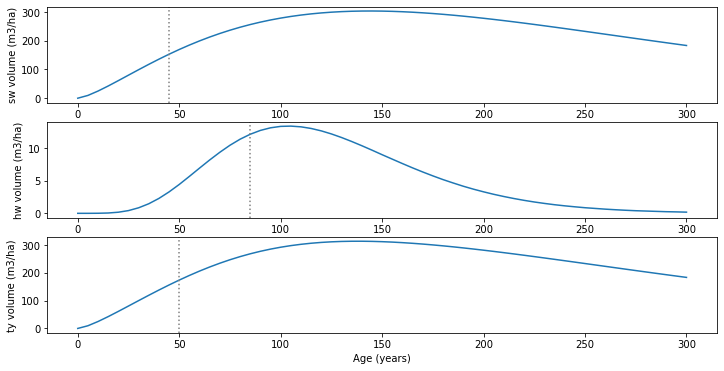

In [5]:
fig, ax = plt.subplots(3, 1, figsize=(12, 6))
df['ty'] = df['sw'] + df['hw']
for i, s in enumerate(['sw', 'hw', 'ty']):
    df['mai_%s' % s] = df[s] / df.index
    df[s].plot(ax=ax[i])
    cmai_age = df['mai_%s' % s].idxmax()
    ax[i].axvline(cmai_age, color='gray', linestyle=':')
    ax[i].set_xlabel('Age (years)')
    ax[i].set_ylabel('%s volume (m3/ha)' % s)

Run the cell below to display an interactive LEV model.

In [6]:
interact(plot_lev,
         R=widgets.FloatSlider(value=100., min=10., max=200., step=5.),
         E=widgets.FloatSlider(value=500., min=0., max=2000., step=100.),
         A=widgets.FloatSlider(value=0., min=-100., max=100., step=10.),
         I=fixed(I),
         Y=fixed(Y),
         P=fixed(P),
         Ch=widgets.FloatSlider(value=500., min=0., max=2000., step=100.),
         r=widgets.FloatSlider(value=0.01, min=0.01, max=0.20, step=0.001),
         N=widgets.IntSlider(value=1, min=1, max=20))

interactive(children=(FloatSlider(value=100.0, description='R', max=200.0, min=10.0, step=5.0), FloatSlider(va…

<function frst318.plot_lev(R, E, A, I, Y, P, Ch, r, N)>

#### Question 4

Using default model parameters, what is the relative contribution to LEV of including rotation 6? Rotation 7?

#### Question 5

Using default model parameters and 5 rotations, what is the IRR of this scenario? What is the IRR if you increase rotation length to 120 years? Using only IRR as a criterion, which rotation length is best.